# Onset asynchrony

## Import dependencies, set constants etc.

In [1]:
from itertools import pairwise, combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

import src.visualise.visualise_utils as vutils
from src import utils
from src.visualise.asynchrony_plots import *

C:\Python Projects\jazz-corpus-analysis\venv\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Load in data
We need to unserialise our list of onsets first

In [2]:
onsets: list = utils.unserialise_object(fr'{utils.get_project_root()}\models\matched_onsets_corpus_chronology')

## Get position of marked beats
Now we can iterate through successive downbeats in a performance and express the position of each marked beat proportionally.

In [3]:
asynchronies = []
# Iterate over every track
for num, track in enumerate(onsets, 1):
    print(f'{num} / {len(onsets)}')
    if track.item['time_signature'] == 3:
        continue
    bandleader = track.item['pianist']
    tempo = track.tempo
    temp = pd.DataFrame(track.summary_dict)
    idx = temp[temp['metre_manual'] == 1].index
    # Iterate through successive downbeats
    for downbeat1, downbeat2 in pairwise(idx):
        # Get all the beats marked between our two downbeats (beat 1 bar 1, beat 1 bar 2)
        bw = temp[(downbeat1 <= temp.index) & (temp.index < downbeat2)]
        sub = bw[utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()]
        # Get the first downbeat of the first bar, and the last downbeat of the second
        first, last = temp[temp.index == downbeat1]['beats'].iloc[0], temp[temp.index == downbeat2]['beats'].iloc[0]
        # Scale our onsets to be proportional with our first and last values
        prop = (sub - first) / (last - first)
        # Drop values after 1/16th note or before 1/32nd note
        upper_bound = (((bw['metre_manual'] - 1) * 1/4) + 1/16)
        lower_bound = ((bw['metre_manual'] - 1) * 1/4) - 1/32
        for col in prop.columns:
            prop[col][(prop[col] < lower_bound) | (prop[col] > upper_bound)] = np.nan
        # Convert values to degrees
        prop *= 360
        prop = pd.concat([prop, bw['metre_manual']], axis=1)
        # Iterate through each column and add values to our list
        for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
            for _, val in prop[[instr, 'metre_manual']].dropna().iterrows():
                asynchronies.append(dict(instr=instr, asynchrony=val[instr], beat=val['metre_manual'], bandleader=bandleader, tempo=tempo))
df = pd.DataFrame(asynchronies)

1 / 300
2 / 300
3 / 300
4 / 300
5 / 300
6 / 300
7 / 300
8 / 300
9 / 300
10 / 300
11 / 300
12 / 300
13 / 300
14 / 300
15 / 300
16 / 300
17 / 300
18 / 300
19 / 300
20 / 300
21 / 300
22 / 300
23 / 300
24 / 300
25 / 300
26 / 300
27 / 300
28 / 300
29 / 300
30 / 300
31 / 300
32 / 300
33 / 300
34 / 300
35 / 300
36 / 300
37 / 300
38 / 300
39 / 300
40 / 300
41 / 300
42 / 300
43 / 300
44 / 300
45 / 300
46 / 300
47 / 300
48 / 300
49 / 300
50 / 300
51 / 300
52 / 300
53 / 300
54 / 300
55 / 300
56 / 300
57 / 300
58 / 300
59 / 300
60 / 300
61 / 300
62 / 300
63 / 300
64 / 300
65 / 300
66 / 300
67 / 300
68 / 300
69 / 300
70 / 300
71 / 300
72 / 300
73 / 300
74 / 300
75 / 300
76 / 300
77 / 300
78 / 300
79 / 300
80 / 300
81 / 300
82 / 300
83 / 300
84 / 300
85 / 300
86 / 300
87 / 300
88 / 300
89 / 300
90 / 300
91 / 300
92 / 300
93 / 300
94 / 300
95 / 300
96 / 300
97 / 300
98 / 300
99 / 300
100 / 300
101 / 300
102 / 300
103 / 300
104 / 300
105 / 300
106 / 300
107 / 300
108 / 300
109 / 300
110 / 300
111 / 30

In [7]:
print(df[df['instr'] == 'piano'].shape)

(75842, 5)


## Clean dataset

In [4]:
# First, we sort the dataset so that instruments are in the order piano-bass-drums -- this is for hue mapping
df = (
    df.set_index('instr')
    .loc[utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()]
    .reset_index(drop=False)
)

In [5]:
# Offset the asynchrony column so that drums average beat 1 is shifted to 0
df['asynchrony_offset'] = df['asynchrony'] - df[(df['instr'] == 'drums') & (df['beat'] == 1)]['asynchrony'].mean()
# Adjust the asynchrony values so that asynchrony is independent of beat location
df['asynchrony_adjusted'] = (df['asynchrony'] / 360) - ((df['beat'] - 1) * 1/4)
# Adjust the offset beat values
df['asynchrony_adjusted_offset'] = (df['asynchrony_offset'] / 360) - ((df['beat'] - 1) * 1/4)

## Create circular plot of asynchrony by beat number

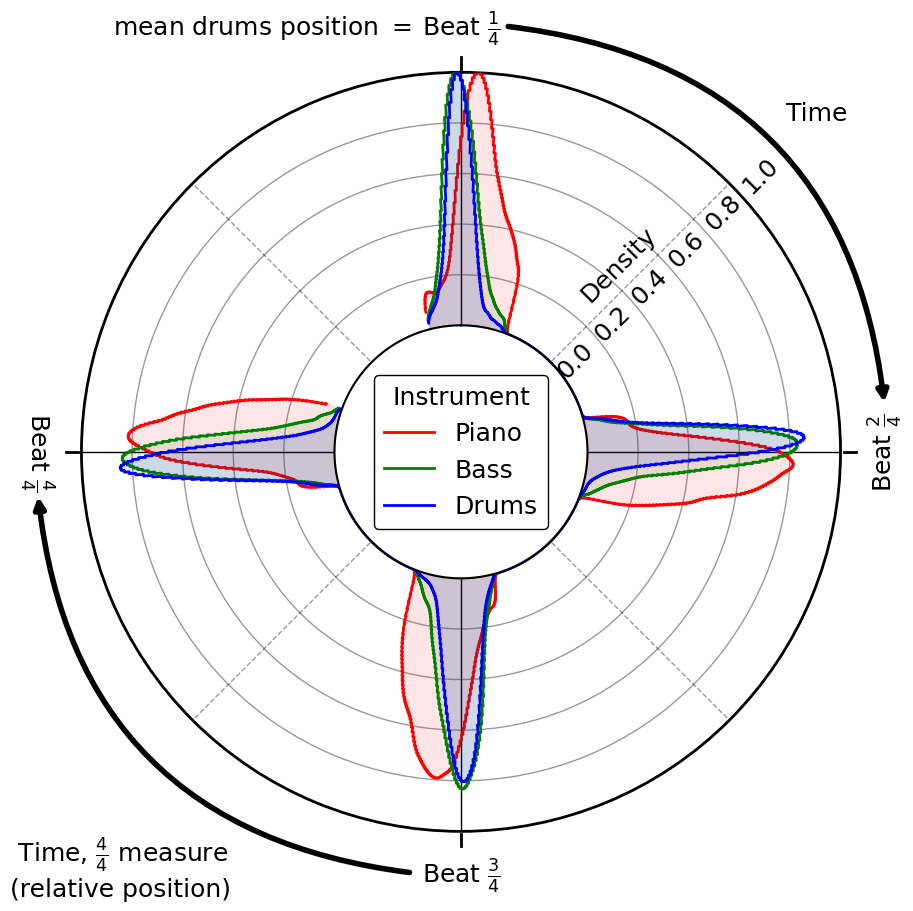

In [13]:
PolarPlotAsynchrony(df).create_plot()
plt.show()

## Bootstrap peaks in KDE

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

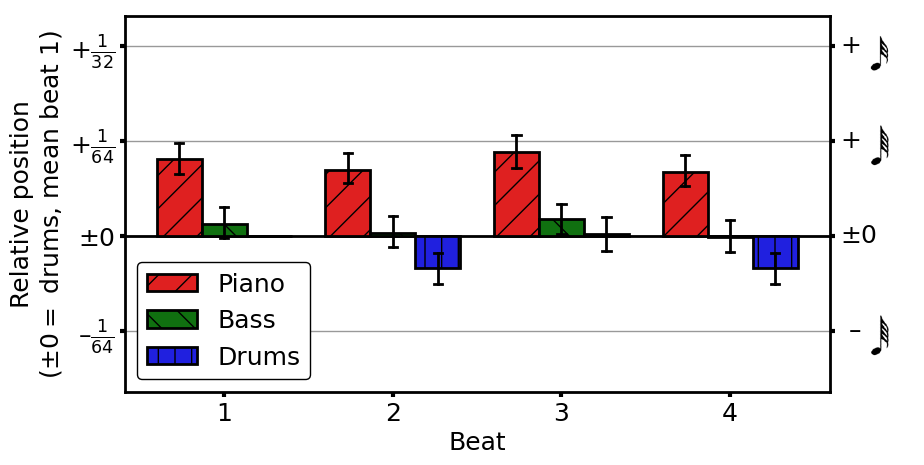

In [17]:
BarPlotProportionalAsynchrony(df).create_plot()

## Plot histogram of beat distribution

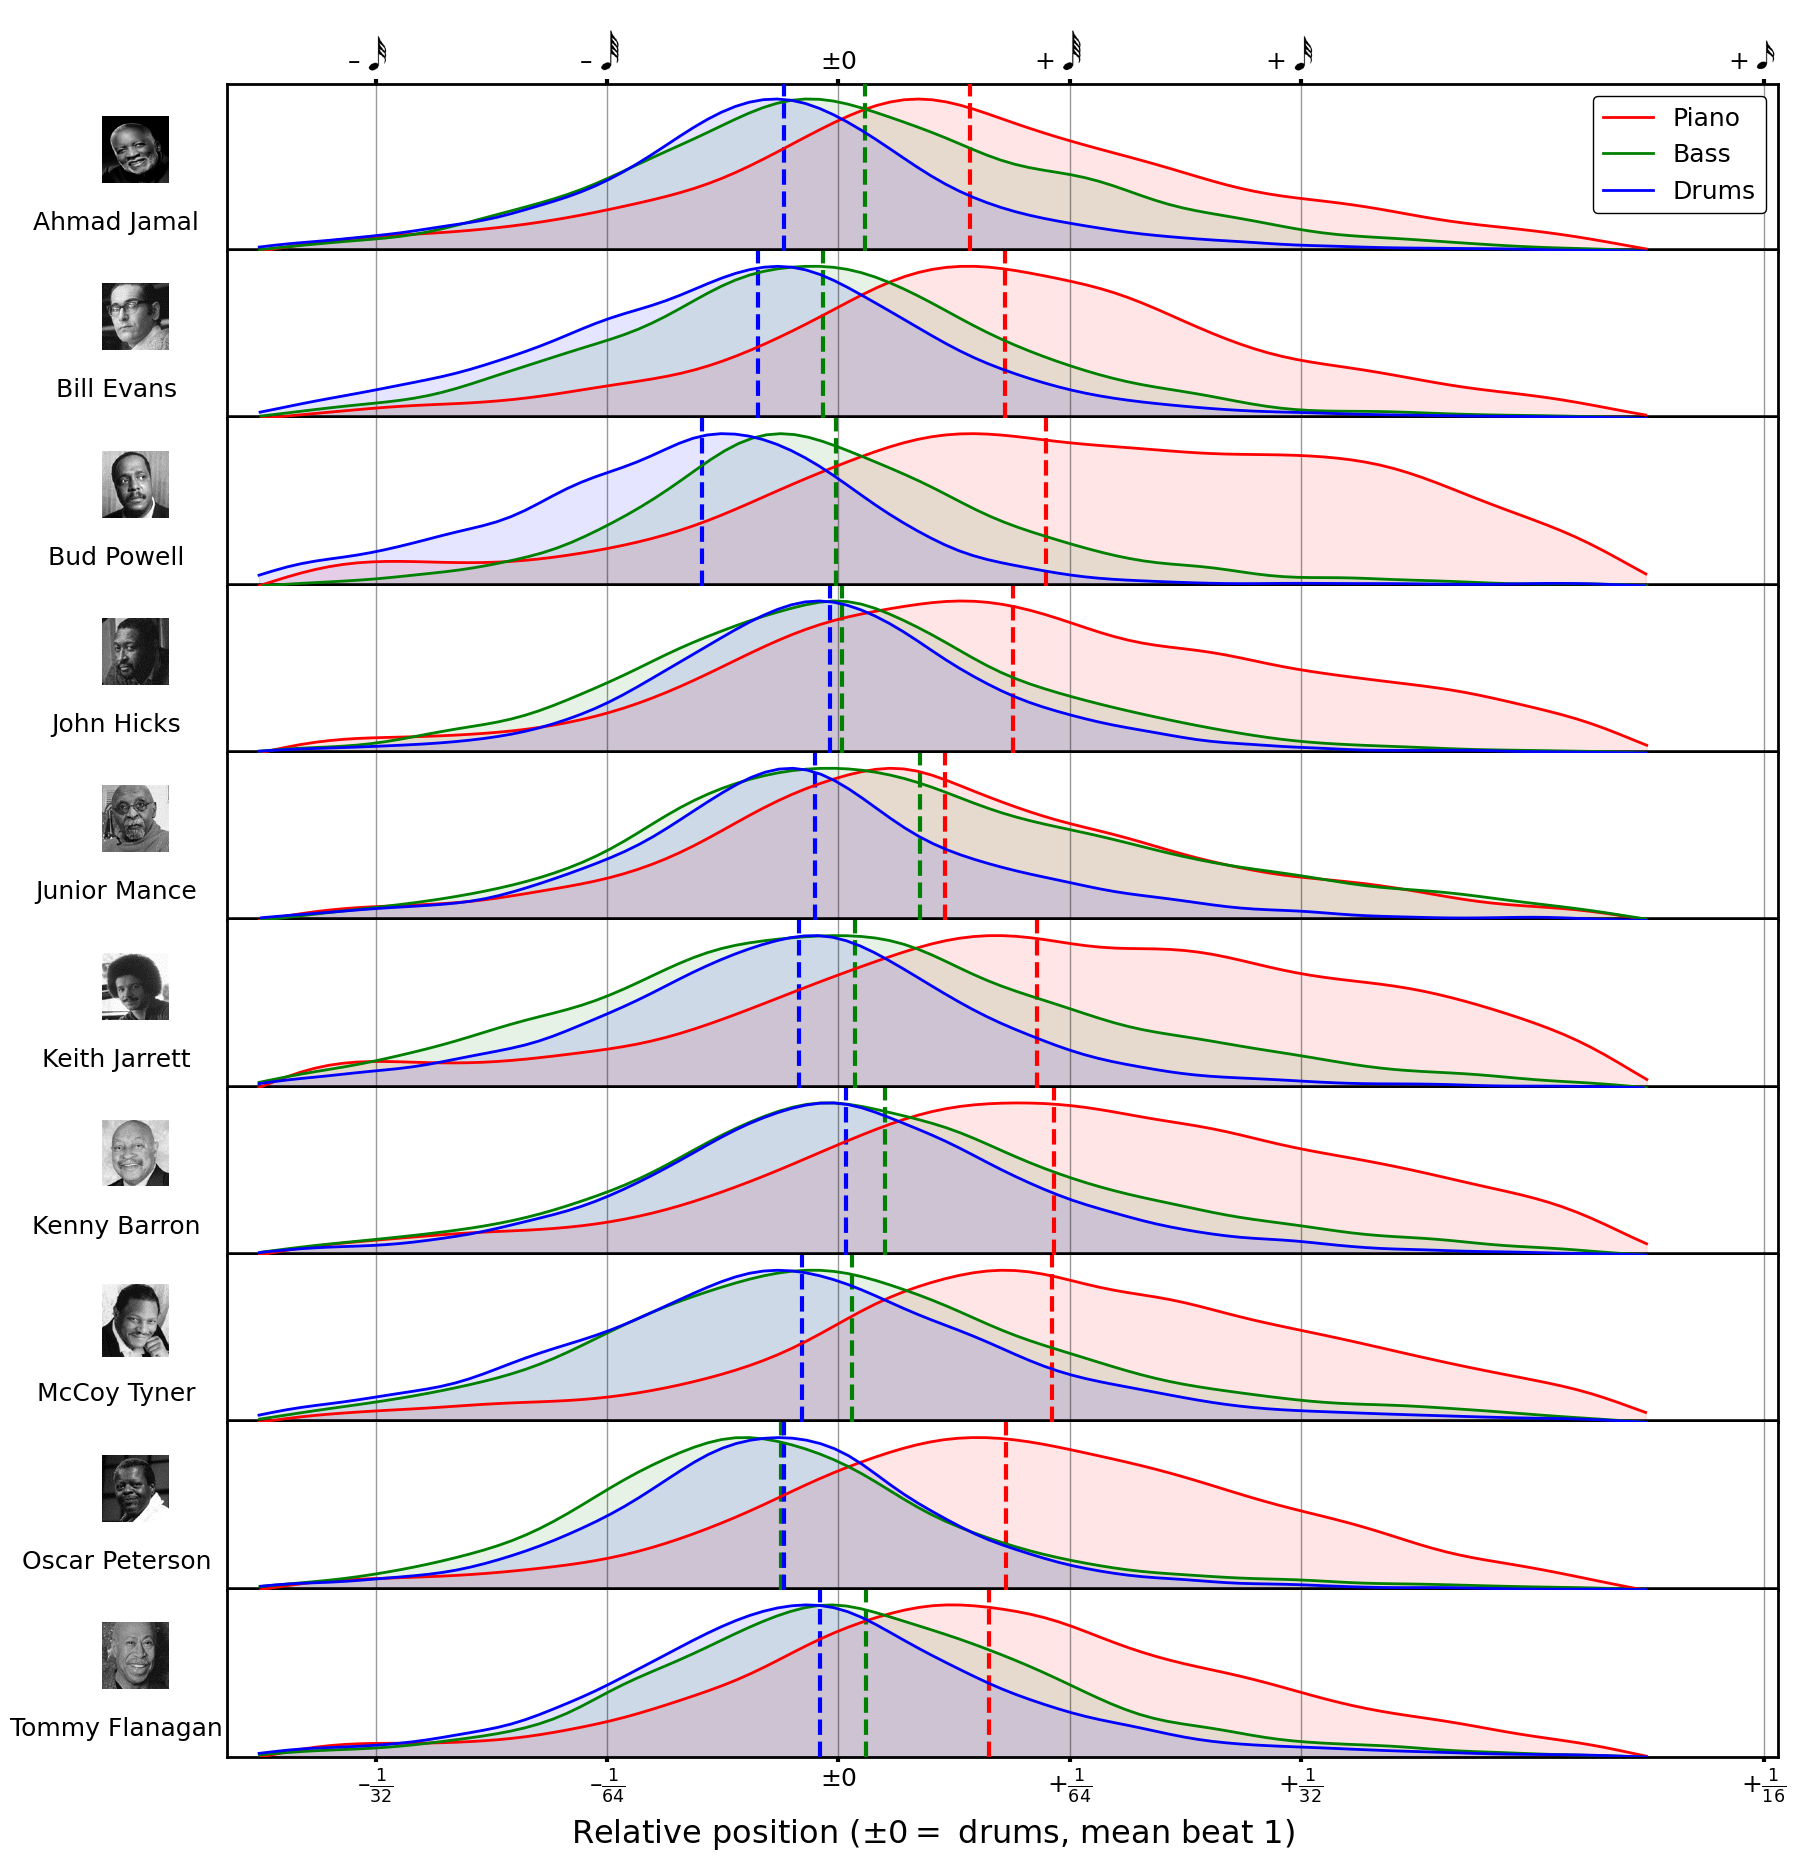

In [73]:
HistPlotProportionalAsynchronyTrios(df).create_plot()
plt.show()

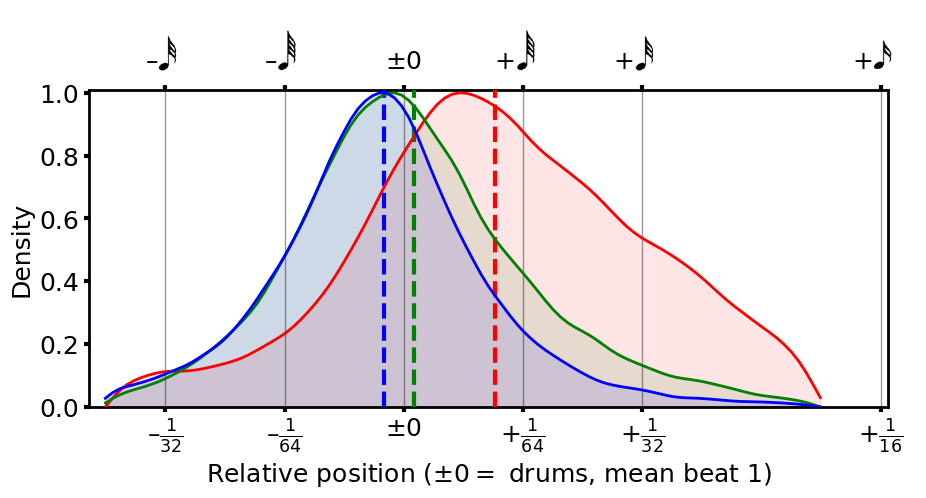

In [22]:
HistPlotProportionalAsynchrony(df).create_plot()
plt.show()

## Bootstrap differences per instrument

In [9]:
grouped = df.groupby(['bandleader', 'instr', 'beat']).mean().reset_index(drop=False)
bootstraps = []
for i1, i2 in combinations(grouped['instr'].unique(), 2):
    print(i1, i2)
    val1 = grouped[grouped['instr'] == i1]['asynchrony_adjusted_offset']
    val2 = grouped[grouped['instr'] == i2]['asynchrony_adjusted_offset']
    true_mean = val1.mean() - val2.mean()
    boots = [val1.sample(frac=1, random_state=s, replace=True).mean() - val2.sample(frac=1, random_state=s, replace=True).mean() for s in range(vutils.N_BOOT)]
    bootstraps.append(dict(instr1=i1, instr2=i2, low=np.percentile(boots, 2.5), mean=true_mean, high=np.percentile(boots, 97.5)))
pd.DataFrame(bootstraps)

bass drums
bass piano
drums piano


,instr1,instr2,low,mean,high
0,bass,drums,0.002921,0.003911,0.004920
1,bass,piano,-0.011950,-0.010774,-0.009501
2,drums,piano,-0.016023,-0.014685,-0.013374


## Model differences in piano 'lateness' vs tempo

In [24]:
tempo_res = []
for idx, grp in df.groupby(['bandleader', 'tempo']):
    if len(grp.dropna()) < 15:
        continue

    piano = grp[grp['instr'] == 'piano']['asynchrony_adjusted_offset'].mean()
    for instr in ['bass', 'drums']:
        other = grp[grp['instr'] == instr]['asynchrony_adjusted_offset'].mean()
        other_diff = piano - other
        tempo_res.append(dict(bandleader=idx[0], tempo=idx[1], instr=instr, diff=other_diff))
tempo_df = pd.DataFrame(tempo_res).dropna()
tempo_df['tempo_standard'] = (tempo_df['tempo'] - tempo_df['tempo'].mean()) / tempo_df['tempo'].std()

In [ ]:
RegPlotPianistAsynchrony(tempo_df).create_plot()
plt.show()

104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60

In [ ]:
md = smf.mixedlm(
    "diff ~ tempo_standard * C(instr, Treatment(reference='bass'))",
    data=tempo_df,
    groups=tempo_df['bandleader'],
    re_formula="0 + tempo_standard + C(instr, Treatment(reference='bass'))"
).fit()
print(md.summary())
# Variance explained by the fixed effects: we need to use md.predict() with the underlying data to get this
var_fixed = md.predict().var()
# Variance explained by the random effects
var_random = float(md.cov_re.to_numpy().mean())
# Variance of the residuals
var_resid = md.scale
# Total variance of the model
total_var = var_fixed + var_random + var_resid
# Calculate the r2 values and append to the model
print('conditional_r2:', (var_fixed + var_random) / total_var)
print('marginal_r2:', var_fixed / total_var)

                                                  Mixed Linear Model Regression Results
Model:                                        MixedLM                            Dependent Variable:                            diff     
No. Observations:                             556                                Method:                                        REML     
No. Groups:                                   10                                 Scale:                                         0.0000   
Min. group size:                              52                                 Log-Likelihood:                                1974.8449
Max. group size:                              60                                 Converged:                                     Yes      
Mean group size:                              55.6                                                                                       
------------------------------------------------------------------------------------

## Drums autocorrelation weak v strong beats

In [17]:
weak_iois = []
strong_iois = []
# Iterate over every track
for num, track in enumerate(onsets[:1], 1):
    print(f'{num} / {len(onsets)}')
    if track.item['time_signature'] == 3:
        continue
    temp = pd.DataFrame(track.summary_dict)[['drums', 'metre_manual']]
    temp['ioi'] = temp['drums'].diff()
    print(temp)

1 / 300
         drums  metre_manual       ioi
0     0.185760           3.0       NaN
1     0.377324           4.0  0.191565
2     0.606621           1.0  0.229297
3     0.789478           2.0  0.182857
4     1.018776           3.0  0.229297
5     1.213243           4.0  0.194467
6     1.416417           1.0  0.203175
7     1.631202           2.0  0.214785
8     1.848889           3.0  0.217687
9          NaN           4.0       NaN
10    2.275556           1.0       NaN
11    2.458413           2.0  0.182857
12    2.673197           3.0  0.214785
13    2.882177           4.0  0.208980
14         NaN           1.0       NaN
15    3.305941           2.0       NaN
16    3.512018           3.0  0.206077
17         NaN           4.0       NaN
18    3.947392           1.0       NaN
19    4.150567           2.0  0.203175
20    4.376961           3.0  0.226395
21    4.577234           4.0  0.200272
22    4.792018           1.0  0.214785
23    5.012608           2.0  0.220590
24    5.233197   

## Get piano - drums/bass asynchronies

In [3]:
from src.features.features_utils import ProportionalAsynchrony

In [4]:
asynchronies = []
# Iterate over every track
for num, track in enumerate(onsets, 1):
    print(f'{num} / {len(onsets)}')
    if track.item['time_signature'] == 3:
        continue
    summary_df = pd.DataFrame(track.summary_dict)
    asy = ProportionalAsynchrony(summary_df=summary_df, my_instr_name='piano').asynchronies
    piano = asy[asy['instr'] == 'piano'].reset_index(drop=True)['asynchrony_adjusted']
    bass = asy[asy['instr'] == 'bass'].reset_index(drop=True)['asynchrony_adjusted']
    drums = asy[asy['instr'] == 'drums'].reset_index(drop=True)['asynchrony_adjusted']
    bass_asy = (piano - bass).dropna().values
    drums_asy = (piano - drums).dropna().values
    for instr, asyncs in zip(['bass', 'drums'], [bass_asy, drums_asy]):
        for async_ in asyncs:
            asynchronies.append(dict(instr=instr, bandleader=track.item['pianist'], asynchrony=async_))

1 / 300
2 / 300
3 / 300
4 / 300
5 / 300
6 / 300
7 / 300
8 / 300
9 / 300
10 / 300
11 / 300
12 / 300
13 / 300
14 / 300
15 / 300
16 / 300
17 / 300
18 / 300
19 / 300
20 / 300
21 / 300
22 / 300
23 / 300
24 / 300
25 / 300
26 / 300
27 / 300
28 / 300
29 / 300
30 / 300
31 / 300
32 / 300
33 / 300
34 / 300
35 / 300
36 / 300
37 / 300
38 / 300
39 / 300
40 / 300
41 / 300
42 / 300
43 / 300
44 / 300
45 / 300
46 / 300
47 / 300
48 / 300
49 / 300
50 / 300
51 / 300
52 / 300
53 / 300
54 / 300
55 / 300
56 / 300
57 / 300
58 / 300
59 / 300
60 / 300
61 / 300
62 / 300
63 / 300
64 / 300
65 / 300
66 / 300
67 / 300
68 / 300
69 / 300
70 / 300
71 / 300
72 / 300
73 / 300
74 / 300
75 / 300
76 / 300
77 / 300
78 / 300
79 / 300
80 / 300
81 / 300
82 / 300
83 / 300
84 / 300
85 / 300
86 / 300
87 / 300
88 / 300
89 / 300
90 / 300
91 / 300
92 / 300
93 / 300
94 / 300
95 / 300
96 / 300
97 / 300
98 / 300
99 / 300
100 / 300
101 / 300
102 / 300
103 / 300
104 / 300
105 / 300
106 / 300
107 / 300
108 / 300
109 / 300
110 / 300
111 / 30

In [5]:
asy_df = pd.DataFrame(asynchronies)

In [6]:
jm = asy_df[(asy_df['instr'] == 'bass') & (asy_df['bandleader'] == 'Bud Powell')]['asynchrony']
means = [jm.sample(frac=1, replace=True, random_state=i).mean() for i in range(10000)]
print(np.quantile(means, 0.025), np.quantile(means, 0.975))

0.014739912913739037 0.016385838084267027


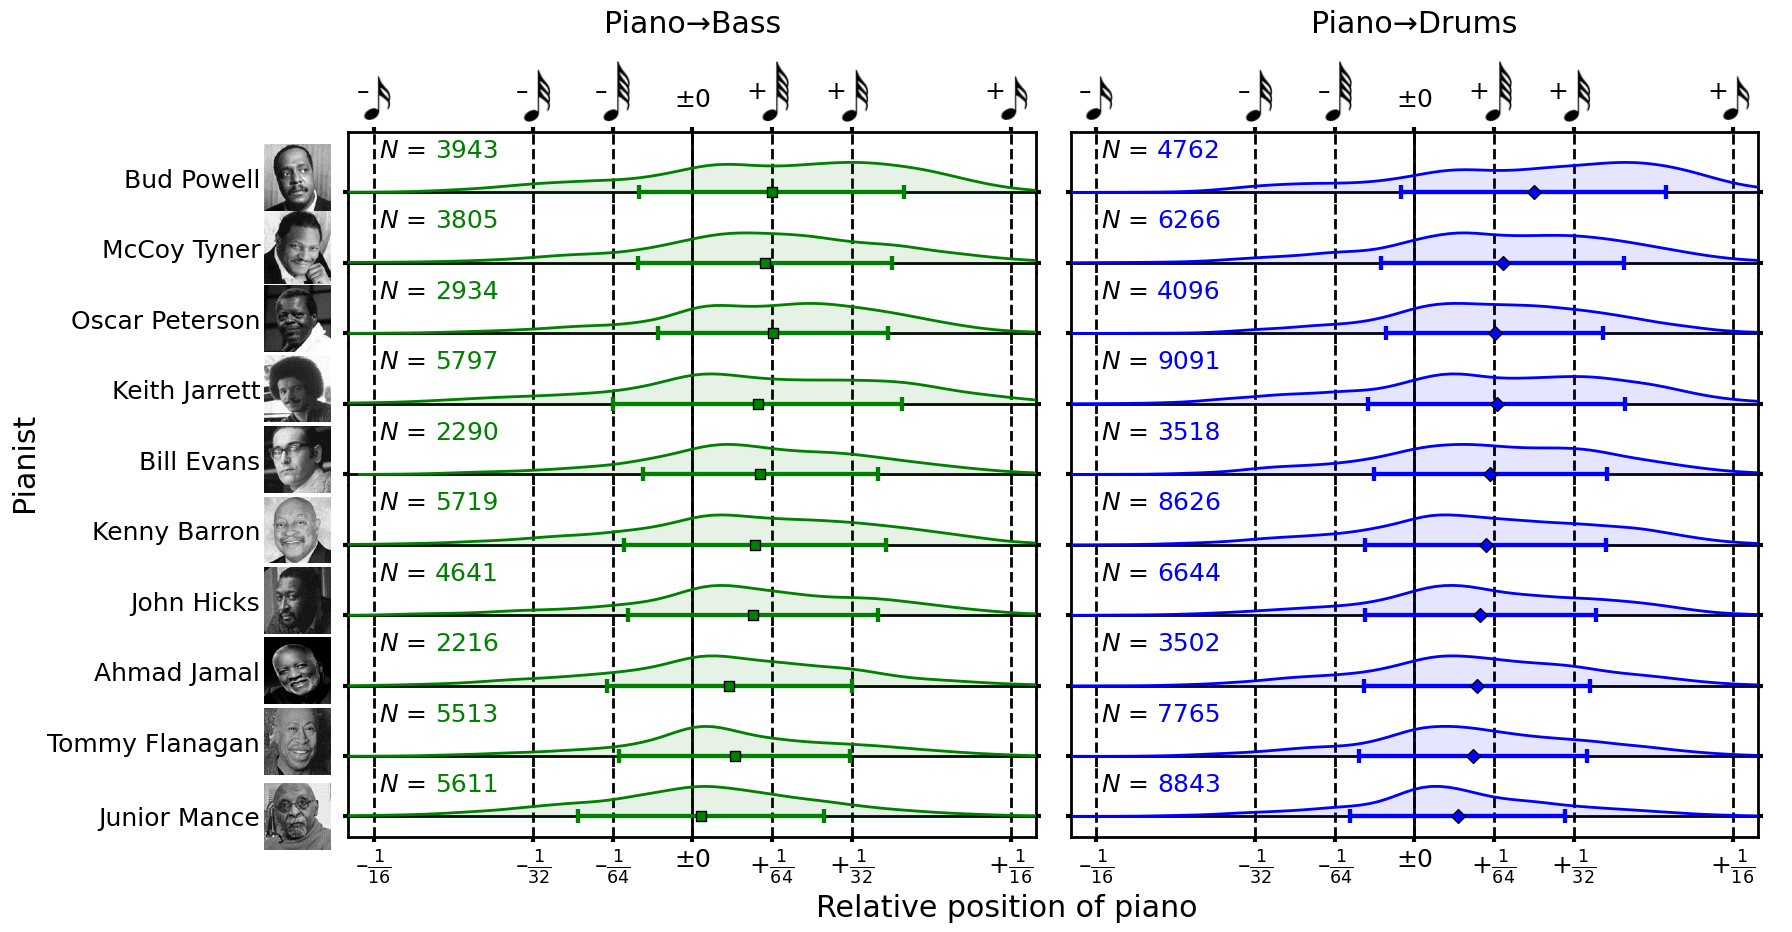

In [12]:
import matplotlib as mpl
import scipy.stats as stats


class HistPlotProportionalAsynchronyTriosPiano(vutils.BasePlot):
    img_loc = fr'{utils.get_project_root()}\references\images\musicians'
    PLOT_KWS = dict(lw=vutils.LINEWIDTH, ls=vutils.LINESTYLE, zorder=10)
    FILL_KWS = dict(alpha=0.1, zorder=5)
    VLINE_KWS = dict(linestyle='dashed', alpha=1, zorder=1, linewidth=vutils.LINEWIDTH * 1.5)

    def __init__(self, async_df: pd.DataFrame, **kwargs):
        """Called when initialising the class"""
        self.corpus_title = 'corpus_chronology'
        # Initialise the base plot with our given kwargs
        super().__init__(figure_title=fr'asynchrony_plots\histplot_asynchronytriospiano_{self.corpus_title}', **kwargs)
        self.df = async_df.copy(deep=True)
        order = reversed(
            self.df.groupby('bandleader', as_index=False)
            ['asynchrony']
            .mean()
            .sort_values(by='asynchrony')
            ['bandleader']
            .values
        )
        self.df = self.df.set_index('bandleader').loc[order].reset_index(drop=False)
        self.fig, self.ax = plt.subplots(
            async_df['bandleader'].nunique(), 2, figsize=(vutils.WIDTH, vutils.WIDTH / 2), sharex=True, sharey=False,
            gridspec_kw=dict(height_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
        )

    @staticmethod
    def _kde(vals):
        # Fit the actual KDE to the data, using the default parameters
        kde = stats.gaussian_kde(vals.T)
        # Create a linear space of integers ranging from our lowest to our highest BUR
        x = np.linspace(vals.min(), vals.max(), 100)[:, np.newaxis].T[0]
        # Evaluate the KDE on our linear space of integers
        y = kde.evaluate(x)
        y = np.array([(y_ - min(y)) / (max(y) - min(y)) for y_ in y])
        return x, y

    def _create_plot(self):
        for (idx, grp), ax_row in zip(self.df.groupby('bandleader', sort=False), self.ax):
            zi = zip(grp.groupby('instr', sort=False), [vutils.GREEN, vutils.BLUE], ax_row, ['s', 'D'])
            for (i, g), col, a, mark in zi:
                vals = g['asynchrony'].values
                x, y = self._kde(vals)
                a.plot(x, y, color=col, **self.PLOT_KWS, label=i.title())
                a.fill_between(x, y, color=col, **self.FILL_KWS)
                me = np.mean(vals)
                std = np.std(vals)
                a.scatter(
                    me, 0, color=col, marker=mark, lw=vutils.LINEWIDTH / 2, edgecolor=vutils.BLACK, s=50, zorder=15
                )
                a.errorbar(
                    x=[me, me], y=[0, 0], xerr=std, zorder=10, linewidth=vutils.LINEWIDTH * 1.5,
                    color=col, capsize=5, capthick=vutils.LINEWIDTH * 1.5
                )

    def _add_bandleader_images(self, bl: str, ax, y: float = 0.5, ):
        fpath = fr'{self.img_loc}\{bl.replace(" ", "_").lower()}.png'
        img = mpl.offsetbox.OffsetImage(
            plt.imread(fpath), clip_on=False, transform=ax.transAxes, zoom=0.5
        )
        ab = mpl.offsetbox.AnnotationBbox(
            img, (-1/16 - 0.015, y), xycoords='data', clip_on=False, transform=ax.transAxes,
            annotation_clip=False, bboxprops=dict(edgecolor='none', facecolor='none')
        )
        ax.add_artist(ab)

    def _add_images(self, y=5.7):
        # ax = self.ax[1]
        for ax in self.ax[1]:
            ax.text(0, y - .25, r'$\pm$0', ha='center', va='center', clip_on=False, zorder=1000)
            for val in [-16, -32, -64, 32, 64, 16]:
                try:
                    img = plt.imread(fr'{utils.get_project_root()}\references\images\notation\notation_{abs(val)}.png')
                except FileNotFoundError:
                    pass
                # If we can get the image, then yield it to add to our plot
                else:
                    ax.text(
                        1/val - 0.001, y, '–' if val < 0 else '+', ha='right', va='center', clip_on=False, zorder=1000
                    )
                    ax.add_artist(mpl.offsetbox.AnnotationBbox(
                        mpl.offsetbox.OffsetImage(img, clip_on=False, zoom=0.75), (1/val, y+.25),
                        frameon=False, xycoords='data', clip_on=False, annotation_clip=False, zorder=0
                     ))

    def _format_ax(self):
        self._add_images()
        for num, ((i, g), ax_row) in enumerate(zip(self.df.groupby('bandleader', sort=False), self.ax)):
            for (idx, grp), ax, col in zip(g.groupby('instr', sort=False), ax_row, [vutils.GREEN, vutils.BLUE]):
                if num == 0:
                    spines = ['bottom']
                    ax.set_title(f'Piano→{idx.title()}', y=2.3, zorder=10000)
                    yl = (-0.35, 2)
                elif num == 9:
                    spines = ['top']
                    yl = (-0.7, 1.65)
                else:
                    spines = ['bottom', 'top']
                    yl = (-0.35, 2)
                ax.text(-1/16 + 0.001, yl[1] - 0.2, '$N$ = ', va='top')
                ax.text(-1/16 + 0.012, yl[1] - 0.2, len(grp), va='top', ha='left', color=col)
                ax.spines[spines].set_visible(False)
                ax.axvline(0, 0, 1, color=vutils.BLACK, linewidth=vutils.LINEWIDTH, linestyle=vutils.LINESTYLE)
                ax.axhline(
                    0, 0, 1, color=vutils.BLACK, linewidth=vutils.LINEWIDTH, linestyle=vutils.LINESTYLE, zorder=0
                )
                plt.setp(ax.spines.values(), linewidth=vutils.LINEWIDTH)
                ax.tick_params(
                    axis='both', bottom=True, right=True, width=vutils.TICKWIDTH,
                    top=True if num == 0 else False, left=True,
                )
                ax.xaxis.grid(True, color=vutils.BLACK, alpha=1, lw=2, ls='dashed', zorder=1)
                ax.tick_params(axis='y', which='major', pad=60)
                lab = ''
                if idx == 'bass':
                    y = 0.5 if num != 9 else 0
                    self._add_bandleader_images(i, ax, y)
                    lab = i
                ax.set(
                    xlim=(-1/16 - 0.005, 1/16 + 0.005), ylim=yl,
                    yticks=[0], yticklabels=[lab],
                    xticks=[-1/16, -1/32, -1/64, 0, 1/64, 1/32, 1/16],
                    xticklabels=[
                        r'–$\frac{1}{16}$', r'–$\frac{1}{32}$', r'–$\frac{1}{64}$',
                        r'$\pm$0',
                        r'+$\frac{1}{64}$', r'+$\frac{1}{32}$', r'+$\frac{1}{16}$'
                    ]
                )
                if num != 9:
                    plt.setp(ax.yaxis.get_majorticklabels(), va="bottom")

    def _format_fig(self):
        self.fig.supxlabel('Relative position of piano', x=0.55)
        self.fig.supylabel('Pianist')
        # self.fig.subplots_adjust(top=0.95, bottom=0.1, left=0.175, right=0.95, hspace=0, wspace=0)
        # Adjust subplot positioning
        self.fig.subplots_adjust(left=0.2, right=0.95, top=0.85, bottom=0.1, hspace=0, wspace=0.05)


HistPlotProportionalAsynchronyTriosPiano(asy_df).create_plot()
plt.show()

In [29]:
for instr in ['bass', 'drums']:
    means = []
    for state in range(vutils.N_BOOT):
        if state % 10 == 0:
            print(state)
        bls = pd.Series(asy_df['bandleader'].unique()).sample(frac=1, replace=True, random_state=state)
        means.append(pd.concat(asy_df[(asy_df['bandleader'] == bl) & (asy_df['instr'] == instr)]['asynchrony'] for bl in bls).mean())
    print(instr, np.percentile(means, 2.5), np.percentile(means, 97.5))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2